# Importing libraries

In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
# from torchsummary import summary              # for getting the summary of our model
import tensorflow as tf
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

import cv2
from tensorflow.keras.preprocessing import image

from glob import glob
import shutil

from mlxtend.plotting import plot_confusion_matrix

# Data loading and exploring

In [2]:
os.makedirs('/kaggle/working/lung_aca')
os.makedirs('/kaggle/working/lung_scc')
os.makedirs('/kaggle/working/lung_n')

In [3]:
lung_dir1 = "/kaggle/working/"
lungs1 = os.listdir(lung_dir1)
lungs1

['lung_scc',
 'lung_n',
 '.virtual_documents',
 'lung_aca',
 '__notebook_source__.ipynb']

In [4]:
if '__notebook_source__.ipynb' in lungs1:
    os.remove('/kaggle/working/__notebook_source__.ipynb')

if '.virtual_documents' in lungs1:
    shutil.rmtree('/kaggle/working/.virtual_documents')

In [5]:
lung_dir2 = "/kaggle/working/"
lungs2 = os.listdir(lung_dir2)
lungs2

['lung_scc', 'lung_n', 'lung_aca']

In [6]:
folders = glob('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets' + '/*')
print('New Paths: ', folders)

New Paths:  ['/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca', '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc', '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n']


In [7]:
from skimage.filters import threshold_otsu

In [8]:
for i in folders:
    IMAGE_FILES = glob(i + '/*.jpeg')
    train_imgs = IMAGE_FILES
    num_show = len(IMAGE_FILES)
    columns = 5
    
    plt.figure(figsize=(25,12))
    for idx, train_img in enumerate(train_imgs):
        if idx >= num_show:
            break

        t = train_img.split('/')
        # Original:
        bgrimg = cv2.imread(train_img)
        # Grayscle:
        grayimg = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2GRAY)
        # Otsu Thresold:
        thresh_val = threshold_otsu(grayimg)
        otsu=np.where(grayimg>thresh_val,1,0)

        cv2.imwrite('/kaggle/working/' + t[6] + '/' + t[7], otsu)

<Figure size 1800x864 with 0 Axes>

<Figure size 1800x864 with 0 Axes>

<Figure size 1800x864 with 0 Axes>

# Show some example for lung cancer

In [9]:
lung_dir = "/kaggle/working/"
lungs = os.listdir(lung_dir)
lungs

['lung_scc', 'lung_n', 'lung_aca']

In [10]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for lung in lungs:
    nums_train[lung] = len(os.listdir(lung_dir + '/' + lung))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
lung_scc,5000
lung_n,5000
lung_aca,5000


In [11]:
# Function to show image
train = ImageFolder(lung_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

# Lung_aca

Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)


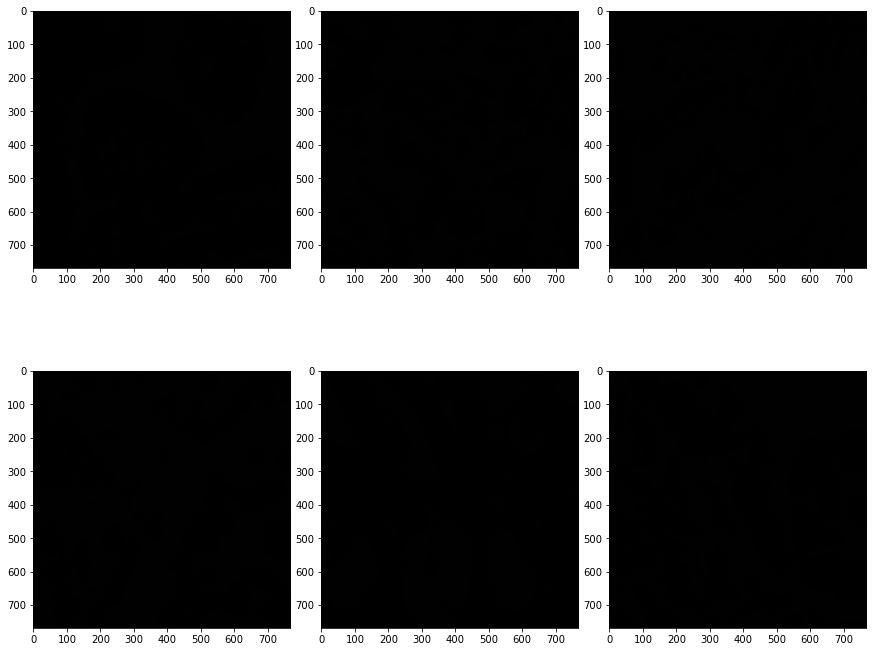

In [19]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[1100]))
axs[1, 0].imshow(show_image(*train[2010]))
axs[1,1].imshow(show_image(*train[3500]))
axs[0,2].imshow(show_image(*train[4120]))
axs[1,2].imshow(show_image(*train[4860]))

# Lung_n

Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)


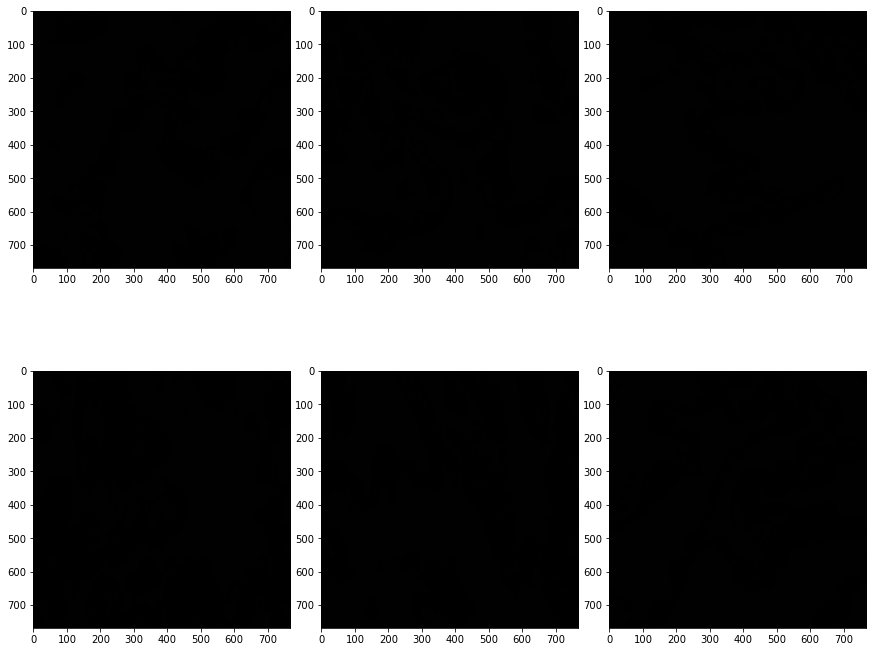

In [13]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5010]))
axs[0,1].imshow(show_image(*train[6050]))
axs[1, 0].imshow(show_image(*train[7000]))
axs[1,1].imshow(show_image(*train[7500]))
axs[0,2].imshow(show_image(*train[8000]))
axs[1,2].imshow(show_image(*train[8620]))

# Lung_scc

Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)


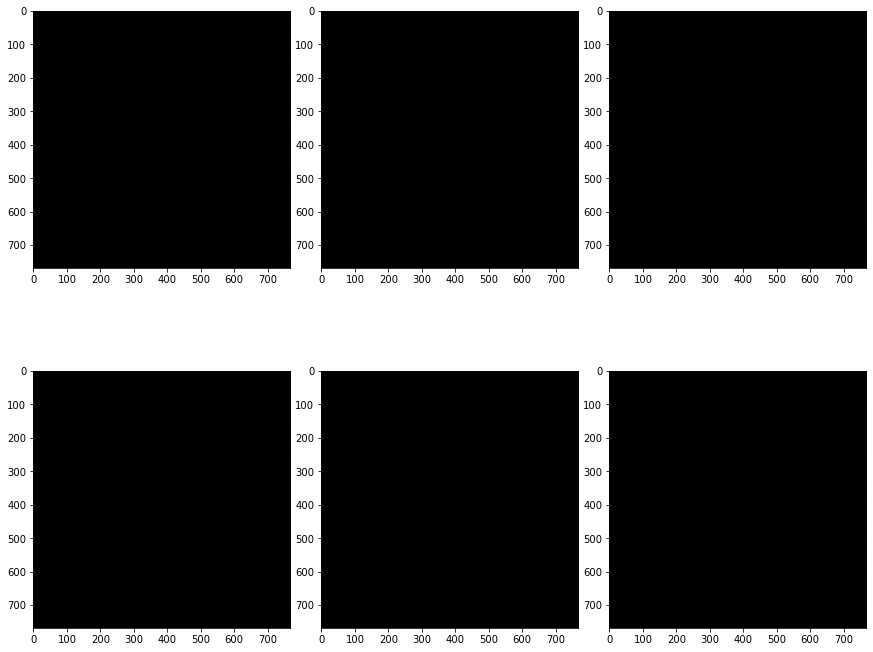

In [14]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[11001]))
axs[0,1].imshow(show_image(*train[12000]))
axs[1, 0].imshow(show_image(*train[13050]))
axs[1,1].imshow(show_image(*train[14000]))
axs[0,2].imshow(show_image(*train[14200]))
axs[1,2].imshow(show_image(*train[14800]))

# Modeling

In [15]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(lung_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(lung_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=False)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [16]:
unique, counts = np.unique(val_data.classes, return_counts=True)
dict(zip(unique, counts))

{0: 1000, 1: 1000, 2: 1000}

# model_1

In [17]:
model_1 = keras.models.Sequential()
model_1.add(keras.layers.Conv2D(8, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.05))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.15))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(128, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(3, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

2023-02-03 17:14:32.577481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:14:32.579000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:14:32.579731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 17:14:32.581207: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
dropout (Dropout)            (None, 222, 222, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        4

In [22]:
history = model_1.fit(train_data,
          validation_data=val_data,
          epochs = 5)

Epoch 1/5
188/188 [==============================] - 161s 856ms/step - loss: 1.0987 - accuracy: 0.3314 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/5
188/188 [==============================] - 161s 854ms/step - loss: 1.0987 - accuracy: 0.3298 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/5
188/188 [==============================] - 161s 855ms/step - loss: 1.0987 - accuracy: 0.3304 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/5
188/188 [==============================] - 158s 843ms/step - loss: 1.0987 - accuracy: 0.3243 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/5
188/188 [==============================] - 156s 830ms/step - loss: 1.0987 - accuracy: 0.3219 - val_loss: 1.0986 - val_accuracy: 0.3333


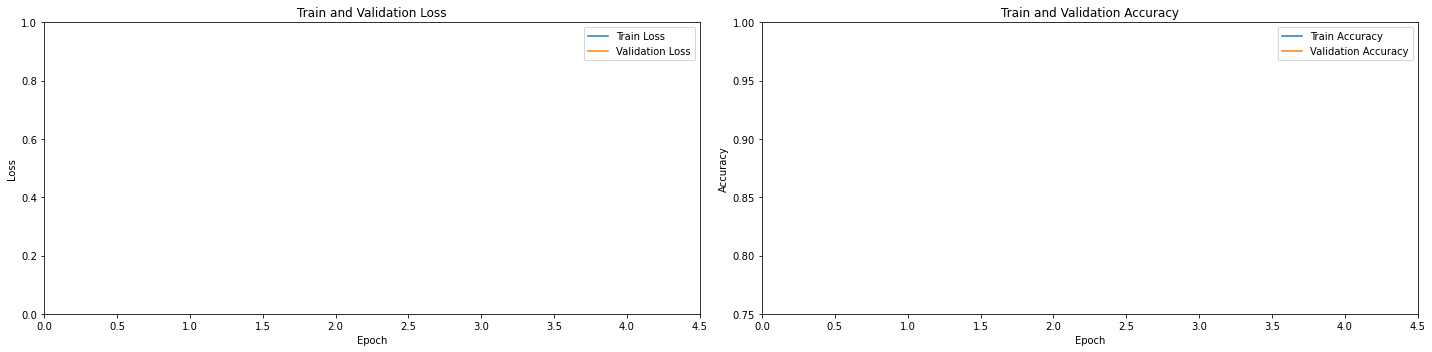

In [23]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 4.5)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 4.5)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [24]:
Y_pred = model_1.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.33      1.00      0.50      1000

    accuracy                           0.33      3000
   macro avg       0.11      0.33      0.17      3000
weighted avg       0.11      0.33      0.17      3000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


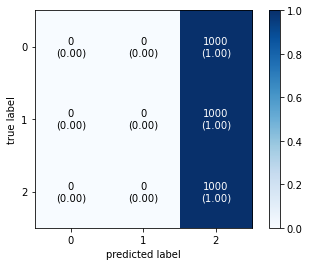

In [25]:
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()